# Mouse ESC-Endoderm example

*You are seeing the
notebook output generated by
[Literate.jl](https://github.com/fredrikekre/Literate.jl) from the
[Julia source file](<unknown>/examples/data_mesc/script.jl).
The rendered HTML can be viewed [in the docs](https://juliaoptimaltransport.github.io/OptimalTransport.jl/dev/examples/data_mesc/).*

The dataset for this example can be found from the [SCODE Github repo](https://github.com/hmatsu1226/SCODE).

## Load packages

In [1]:
using NPZ
using NNlib
using OptimalTransport
using StatsBase
using SparseArrays
using LinearAlgebra
using Plots
using LaTeXStrings
using Graphs
using GraphSignals
using NearestNeighbors
using ProgressMeter
using Discretizers
import scNetworkInference as scN;
using Suppressor
using CSV, DataFrames
using Printf

## Load files
Load dataset and reference

In [2]:
cd("../../../examples/data_mesc")
X = relu.(npzread("X.npy") .- 1e-2)
X_pca = npzread("X_pca.npy")
P = npzread("P_statot.npy")
C = npzread("C.npy")
dpt = npzread("dpt.npy");
J = npzread("J.npy");
J[diagind(J)] .= 0;
J_escape = npzread("J_ESCAPE.npy");
J_escape[diagind(J_escape)] .= 0;
try
    global genes = Array(CSV.read("genes.txt", DataFrame)[:, 2])
catch e
    @info "Exception: $e"
    global genes = ["gene_$i" for i = 1:size(X, 2)]
end;

## Construct neighborhood kernel and couplings

In [3]:
R = quadreg(ones(size(X, 1)), ones(size(X, 1)), C, 2.5 * mean(C));
gene_idxs = vcat([[j, i]' for i = 1:size(X, 2) for j = 1:size(X, 2)]...);
k = 1
π_unif = fill(1 / size(P, 1), size(P, 1))'
Q = (P' .* π_unif) ./ (π_unif * P)';
P_sp = sparse((P^k))
QT_sp = sparse((Q^k)')
R_sp = sparse(R);

## Visualise coupling

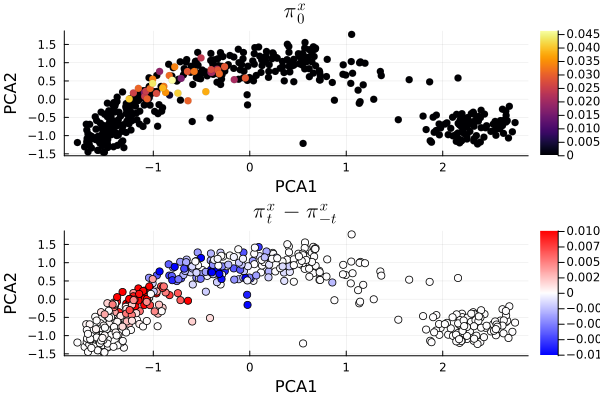

In [4]:
p0 = R[sortperm(dpt)[250], :]
plt = plot(
    scatter(
        X_pca[sortperm(p0), 1],
        X_pca[sortperm(p0), 2];
        marker_z = sort(p0),
        markerstrokewidth = 0,
        alpha = 1.0,
        xlabel = "PCA1",
        ylabel = "PCA2",
        title = L"π_0^x",
    ),
    scatter(
        X_pca[:, 1],
        X_pca[:, 2];
        marker_z = P_sp' * p0 - QT_sp * p0,
        color = :bwr,
        clim = (-0.0101, 0.0101),
        alpha = 1.0,
        xlabel = "PCA1",
        ylabel = "PCA2",
        title = L"\pi^x_{t} - \pi^x_{-t}",
    );
    legend = nothing,
    layout = (2, 1),
)
plt

Construct kNN and Laplacian

In [5]:
kdtree = KDTree(X_pca')
idxs, dists = knn(kdtree, X_pca', 25);
A = spzeros(size(X_pca, 1), size(X_pca, 1));
for (i, j) in enumerate(idxs)
    A[i, j] .= 1.0
end
L = sparse(normalized_laplacian(max.(A, A'), Float64));

Discretization

In [6]:
alg = DiscretizeBayesianBlocks()
disc = scN.discretizations_bulk(X; alg = alg);

## Perform directed inference using CPU
Uncomment to run on CPU. We demonstrate GPU acceleration below.
```
using Base.Threads
@info "Directed inference"
mi_all = zeros(size(X, 1), size(X, 2)^2);
@info "Computing TE scores"
@threads for i = 1:size(X, 1)
    mi_all[i, :] = scN.get_MI(
        X,
        scN.compute_coupling(X, i, P_sp, QT_sp, R_sp),
        gene_idxs[:, 1],
        gene_idxs[:, 2];
        disc = disc,
        alg = alg,
    )
end
```

## Perform directed inference on GPU
Do some setup first (create joint distribution cache, convert expression values to bin-ids)

In [7]:
using CUDA
disc_max_size = maximum(map(x -> length(x[1])-1, disc))
N_blocks = 1
joint_cache = scN.get_joint_cache(size(X, 2) ÷ N_blocks, disc_max_size);
ids_cu = hcat(map(x -> x[2], disc) ...) |> cu;

Copy transition matrices and neighbourhood kernel to CUDA device

In [8]:
P_cu = cu(Array(P_sp))
QT_cu = cu(Array(QT_sp))
R_cu = cu(Array(R_sp));

Estimate TE using GPU

In [9]:
mi_all_gpu = zeros(Float32, size(X, 1), size(X, 2), size(X, 2)) |> cu
for i = 1:size(X, 1)
    gamma, idx0, idx1 = scN.getcoupling_dense_trimmed(i, P_cu, QT_cu, R_cu)
    for ((N_x, N_y), (offset_x, offset_y)) in scN.getblocks(size(X, 2), N_blocks, N_blocks)
        scN.get_MI!(view(mi_all_gpu, i, :, :), joint_cache, gamma, size(X, 2), ids_cu[idx0, :], ids_cu[idx1, :]; offset_x = offset_x, N_x = N_x, offset_y = offset_y, N_y = N_y)
    end
end

Copy back to CPU

In [10]:
mi_all = reshape(Array(mi_all_gpu), size(X, 1), :);

CLR filtering

In [11]:
mi_all_clr = scN.apply_wclr(mi_all, size(X, 2))
mi_all_clr[isnan.(mi_all_clr)] .= 0
@info "Denoising"
w = vec(sqrt.(sum(mi_all_clr .^ 2; dims = 2)))
w /= sum(w)
G = @suppress scN.fitsp(mi_all_clr, L; λ1 = 10.0, λ2 = 0.001, maxiter = 100);

[ Info: Denoising
[ Info: ΔX = 8.978969729033165e-7, ΔZ = 0.0001314616827285016, ΔW = 0.0001469905592507044
[ Info: tr(X'LX) = 2.5787099417493873, 0.5|X-G|^2 = 6.009881731405014, |X|1 = 6626.338619887821


To get a static network, aggregate over dpt < 0.9

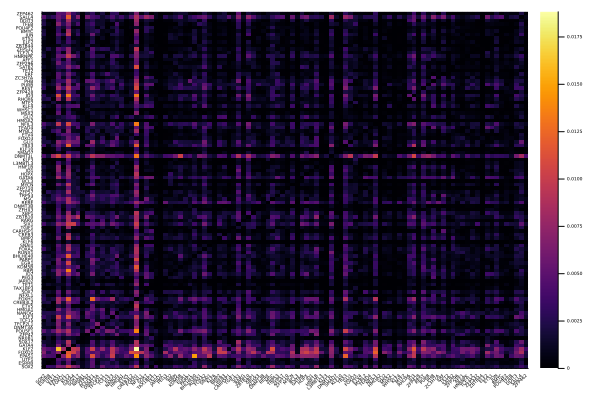

In [12]:
agg_fun = x -> mean(x[dpt.<0.9, :]; dims = 1)
heatmap(
    reshape(agg_fun(G), size(X, 2), size(X, 2)),
    xticks = (collect(1:length(genes)), genes),
    yticks = (collect(1:length(genes)), genes),
    xrotation = 45,
    xtickfontsize = 3,
    ytickfontsize = 3,
)

## Rank genes by the total outgoing TE score

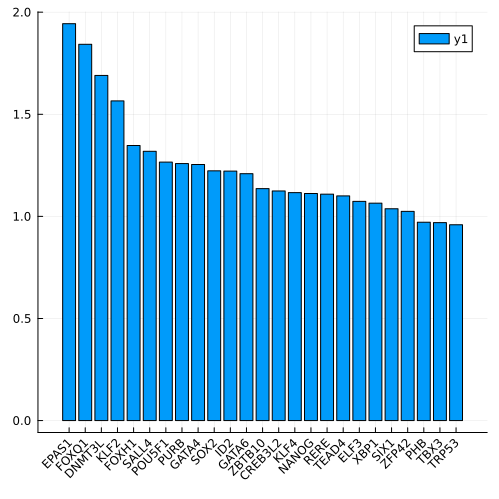

In [13]:
total_TE = vec(sum(reshape(maximum(G; dims = 1), size(X, 2), size(X, 2)); dims = 2))
topk = 25 # show top 25 genes
bar(
    1:topk,
    sort(total_TE; rev = true)[1:topk];
    xticks = (1:topk, genes[sortperm(total_TE; rev = true)][1:topk]),
    xrotation = 45,
    size = (500, 500),
)

Do the same, this time using the ESCAPE gold standard

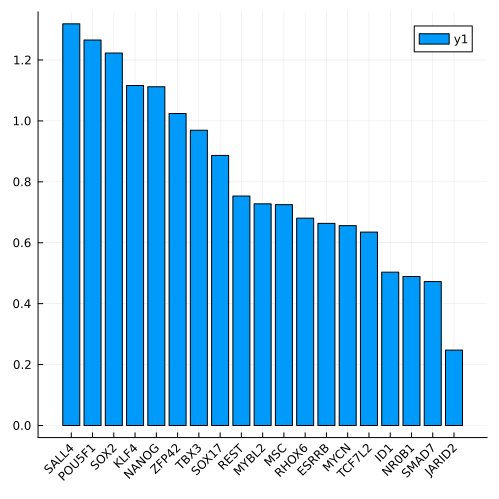

In [14]:
regulators = vec(sum(J_escape; dims = 2) .> 0)
bar(
    1:sum(regulators),
    sort(total_TE[regulators]; rev = true);
    xticks = (
        1:sum(regulators),
        genes[regulators][sortperm(total_TE[regulators]; rev = true)],
    ),
    xrotation = 45,
    size = (500, 500),
)

Investigate NANOG → ELF3 interaction

[ Info: ("Reference for NANOG → ELF3:", [1.0;;])


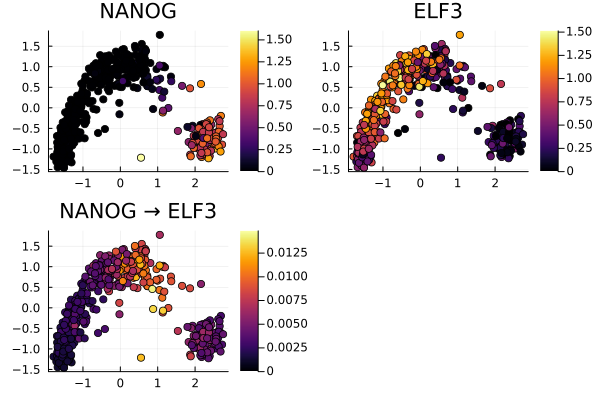

In [15]:
g1 = "NANOG"
g2 = "ELF3"
@info "Reference for $g1 → $g2:", J[genes.==g1, :][:, genes.==g2]
plot(
    scatter(
        X_pca[:, 1],
        X_pca[:, 2],
        marker_z = X[:, findfirst(x -> x == g1, genes)],
        title = g1,
    ),
    scatter(
        X_pca[:, 1],
        X_pca[:, 2],
        marker_z = X[:, findfirst(x -> x == g2, genes)],
        title = g2,
    ),
    scatter(
        X_pca[:, 1],
        X_pca[:, 2],
        marker_z = reshape(G, :, size(X, 2), size(X, 2))[
            :,
            findfirst(x -> x == g1, genes),
            findfirst(x -> x == g2, genes),
        ],
        title = "$(g1) → $(g2)",
        clim = (0, quantile(vec(G[G.>0]), 0.99)),
    );
    legend = nothing,
)

## ROC and PR curves

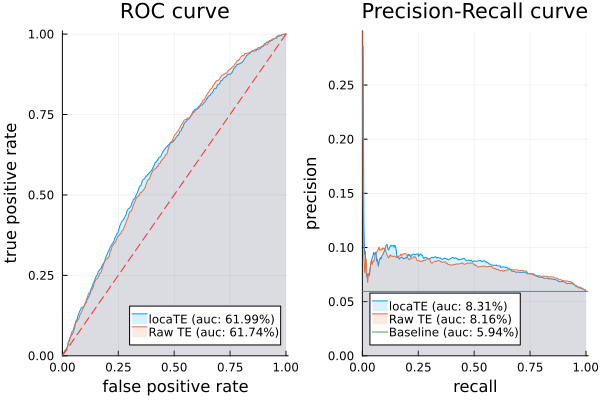

In [16]:
using EvalMetrics
plt1 = rocplot(vec(J), vec(agg_fun(G)); label = "locaTE")
rocplot!(vec(J), vec(agg_fun(mi_all)); label = "Raw TE")
plt2 = prplot(vec(J), vec(agg_fun(G)); label = "locaTE")
prplot!(vec(J), vec(agg_fun(mi_all)); label = "Raw TE", ylim = (0, 0.3))
hline!(
    plt2,
    [mean(J .> 0)];
    label = @sprintf("Baseline (auc: %0.2f%%)", 100 * mean(J .> 0)),
)
plot(plt1, plt2)

ESCAPE reference

┌ Warning: The closest higher feasible true positive rate to some of the required values (0.9966555183946488) is 1.0!
└ @ EvalMetrics ~/.julia/packages/EvalMetrics/ONIFL/src/thresholds.jl:93


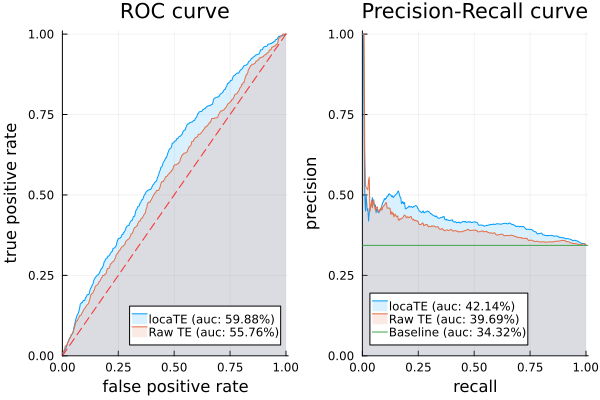

In [17]:
plt1 = rocplot(
    vec(J_escape[regulators, :]),
    vec(reshape(agg_fun(G), size(X, 2), size(X, 2))[regulators, :]);
    label = "locaTE",
)
rocplot!(
    vec(J_escape[regulators, :]),
    vec(reshape(agg_fun(mi_all), size(X, 2), size(X, 2))[regulators, :]);
    label = "Raw TE",
)
plt2 = prplot(
    vec(J_escape[regulators, :]),
    vec(reshape(agg_fun(G), size(X, 2), size(X, 2))[regulators, :]);
    label = "locaTE",
)
prplot!(
    vec(J_escape[regulators, :]),
    vec(reshape(agg_fun(mi_all), size(X, 2), size(X, 2))[regulators, :]);
    label = "Raw TE",
)
hline!(
    plt2,
    [mean(J_escape[regulators, :] .> 0)];
    label = @sprintf("Baseline (auc: %0.2f%%)", 100 * mean(J_escape[regulators, :] .> 0)),
)
plot(plt1, plt2)

## Factor analysis with NMF

In [18]:
qnorm(x, q) = x ./ quantile(vec(x), q)
Cg = cor(X) .^ 2;
Cg[diagind(Cg)] .= 0;
U, V, trace = @suppress scN.fitnmf(
    relu.(qnorm(mi_all_clr, 0.9)),
    [I(size(G, 1)), I(size(G, 2))],
    1e-3 * I + L,
    repeat(vec(Cg), 1, size(X, 1))',
    8;
    α = 10.0,
    β = 0.0,
    λ = [1.0, 1.0],
    μ = [1.0, 1.0],
    iter = 250,
    initialize = :nmf,
    print_iter = 50,
    dictionary = false,
    η = 1.0,
);
G_nmf = Array(U * V');
U = Array(U);
V = Array(V);

[ Info: Initializing NMF decomposition with nmf


Rescale U, V

In [19]:
U .*= mean(V; dims = 1)
V ./= mean(V; dims = 1);

Plot coefficients

In [20]:
try
    using PyCall
    pygam = pyimport_conda("pygam", "pygam")
    #r fit a GAM for each set of coefficients
    coeff_gam = [pygam.LinearGAM(pygam.s(0)).fit(dpt, u) for u in eachcol(U)]
    U_gam = hcat([g.predict(dpt) for g in coeff_gam]...);
    perm = sortperm(vec(sum((U ./ sum(U; dims = 1)) .* dpt; dims = 1)));
    heatmap(U_gam[sortperm(dpt), perm]', xlabel = "pseudotime", ylabel = "Regulatory module")
catch e
end

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*